In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
import pathlib
import seaborn as sns
import pywt

In [81]:
train_data_dir = pathlib.Path('./archive/images/train/')
test_data_dir = pathlib.Path('./archive/images/validation/')
image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

28821


In [82]:
# Function to convert images to wavelet domain
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

c:\Users\dutta\anaconda3\envs\py310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


array([[0.04705882, 0.05882353, 0.94509804, ..., 0.10196078, 0.21960784,
        0.20784314],
       [0.0627451 , 0.03529412, 0.88627451, ..., 0.09411765, 0.21176471,
        0.19607843],
       [0.97254902, 0.89411765, 0.85490196, ..., 0.03921569, 0.22745098,
        0.20392157],
       ...,
       [0.16862745, 0.16862745, 0.21568627, ..., 0.17647059, 0.27058824,
        0.24705882],
       [0.14509804, 0.14117647, 0.19607843, ..., 0.90588235, 0.21176471,
        0.24705882],
       [0.1254902 , 0.12156863, 0.17647059, ..., 0.74901961, 0.05490196,
        0.25098039]])

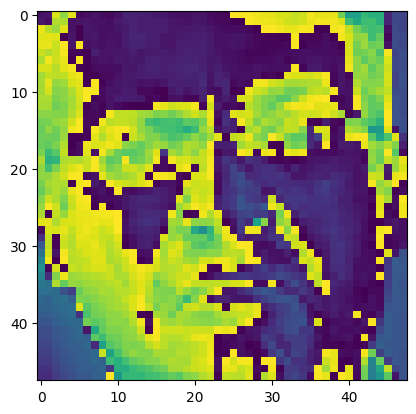

In [83]:
angry = list(train_data_dir.glob('angry/*'))
img = cv2.imread(str(angry[79]))
wvlet = w2d(img,mode = 'db2', level = 5)
wvlet = wvlet/255
plt.imshow(wvlet)
wvlet

In [84]:
face_dict1 = {
    'angry': list(train_data_dir.glob('angry/*')), 
    'fear': list(train_data_dir.glob('fear/*')),
    'happy': list(train_data_dir.glob('happy/*')),
    'neutral': list(train_data_dir.glob('neutral/*')),
    'sad': list(train_data_dir.glob('sad/*')),
    'surprise': list(train_data_dir.glob('surprise/*'))
}
face_dict2 = {
    'angry': list(test_data_dir.glob('angry/*')), 
    'fear': list(test_data_dir.glob('fear/*')),
    'happy': list(test_data_dir.glob('happy/*')),
    'neutral': list(test_data_dir.glob('neutral/*')),
    'sad': list(test_data_dir.glob('sad/*')),
    'surprise': list(test_data_dir.glob('surprise/*'))
}

In [85]:
img = cv2.imread(str(face_dict1['angry'][0]))
img2 = w2d(img,mode = 'db2', level = 5)
img2.shape

(48, 48)

In [86]:
X_test, y_test = [], []
X_train, y_train = [], []
emotion_dict = {
    'angry': 0, 
    'fear': 1,
    'happy': 2,
    'neutral': 3,
    'sad': 4,
    'surprise': 5

}
for emotion, images in face_dict1.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (48,48))
        wvlet = w2d(resized_img,mode = 'db2', level = 5)
        X_train.append(wvlet)
        y_train.append(emotion_dict[emotion])

for emotion, images in face_dict2.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (48,48))
        wvlet = w2d(resized_img,mode = 'db2', level = 5)
        X_test.append(wvlet)
        y_test.append(emotion_dict[emotion])

In [87]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = np.array(X_train)
y_train = np.array(y_train)

print(len(X_test), len(y_test), len(X_train), len(y_train))

6955 6955 28385 28385


In [88]:
X_train_scaled = X_train.reshape(-1,48, 48,1)/255.0  
y_train = to_categorical(y_train, 6)  
X_test_scaled = X_test.reshape(-1,48, 48,1)/255.0
y_test = to_categorical(y_test, 6)
X_train_scaled.shape
X_test_scaled.shape

(6955, 48, 48, 1)

In [89]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

#initilize parameters
num_classes = 6
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64


In [90]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height,1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_92 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_92 (Activation)  (None, 46, 46, 256)       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_93 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_93 (Activation)  (None, 46, 46, 256)     

c:\Users\dutta\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [91]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(X_train_scaled,y_train, batch_size),
                                steps_per_epoch=len(X_train_scaled) / batch_size,                                                                                                                                                                              epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(X_test_scaled,y_test))

Epoch 1/50


C:\Users\dutta\AppData\Local\Temp\ipykernel_8620\1695247372.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(X_train_scaled,y_train, batch_size),


443/443 - 106s - loss: 1.6833 - accuracy: 0.3120 - val_loss: 1.8272 - val_accuracy: 0.2480 - 106s/epoch - 238ms/step
Epoch 2/50
443/443 - 91s - loss: 1.4736 - accuracy: 0.4068 - val_loss: 1.4433 - val_accuracy: 0.4301 - 91s/epoch - 205ms/step
Epoch 3/50
443/443 - 90s - loss: 1.3885 - accuracy: 0.4552 - val_loss: 1.7169 - val_accuracy: 0.3343 - 90s/epoch - 204ms/step
Epoch 4/50
443/443 - 90s - loss: 1.3263 - accuracy: 0.4815 - val_loss: 1.9916 - val_accuracy: 0.3513 - 90s/epoch - 204ms/step
Epoch 5/50
443/443 - 91s - loss: 1.2797 - accuracy: 0.4992 - val_loss: 1.3111 - val_accuracy: 0.4809 - 91s/epoch - 204ms/step
Epoch 6/50
443/443 - 91s - loss: 1.2436 - accuracy: 0.5162 - val_loss: 1.3407 - val_accuracy: 0.4792 - 91s/epoch - 205ms/step
Epoch 7/50
443/443 - 91s - loss: 1.2126 - accuracy: 0.5300 - val_loss: 1.2000 - val_accuracy: 0.5383 - 91s/epoch - 206ms/step
Epoch 8/50
443/443 - 91s - loss: 1.1845 - accuracy: 0.5435 - val_loss: 1.3721 - val_accuracy: 0.4690 - 91s/epoch - 205ms/step
E

In [93]:
model.evaluate(X_test_scaled, y_test)

218/218 [==============================] - 8s 34ms/step - loss: 1.0265 - accuracy: 0.6306


[1.026529312133789, 0.6306254267692566]

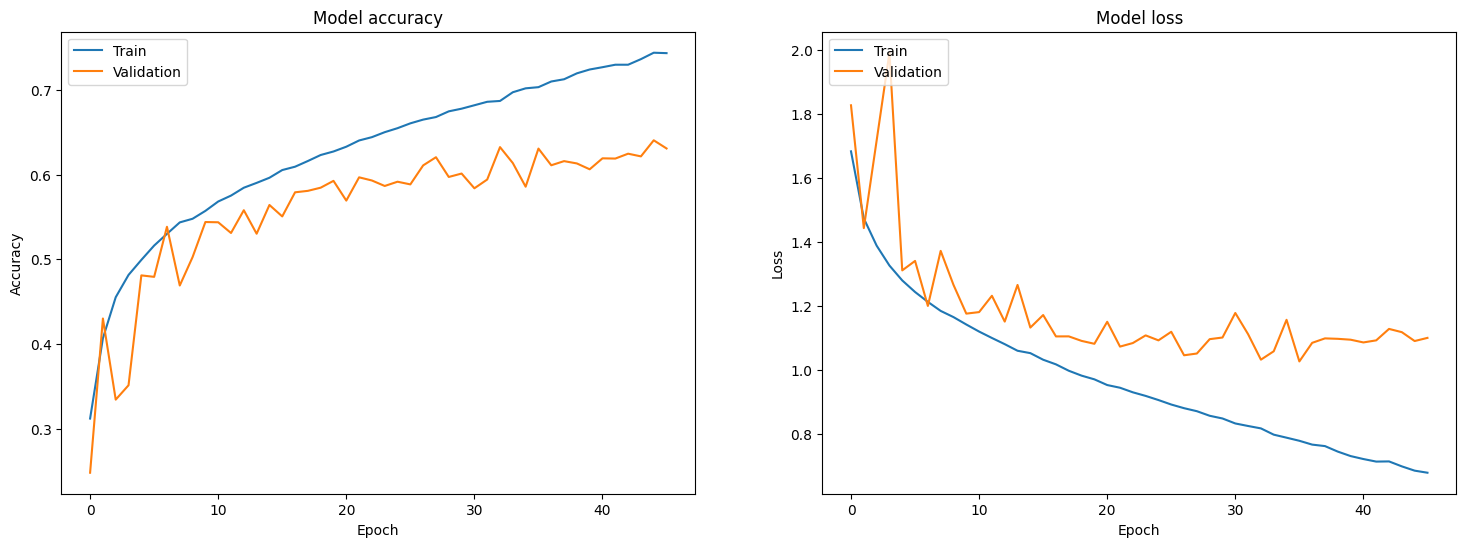

In [97]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [98]:
model.save('face_model.keras')

In [100]:
model.evaluate(X_test_scaled, y_test)

218/218 [==============================] - 8s 34ms/step - loss: 1.0265 - accuracy: 0.6306


[1.026529312133789, 0.6306254267692566]

In [101]:
predictions = model.predict(X_test_scaled)
expression = tf.nn.softmax(predictions[0])
print(np.argmax(expression))


218/218 [==============================] - 7s 33ms/step
4


In [103]:
print(predictions[50])
y_test[50]

[0.22800788 0.27496973 0.00289714 0.3085708  0.16610906 0.01944541]


array([1., 0., 0., 0., 0., 0.], dtype=float32)

In [104]:
from sklearn.metrics import confusion_matrix , classification_report

y_pred = []
for i in predictions:
    y_pred.append(np.argmax(i))

y_test1 = []
for i in y_test:
    y_test1.append(np.argmax(i))

print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.54      0.54       960
           1       0.52      0.44      0.47      1018
           2       0.83      0.84      0.84      1825
           3       0.53      0.59      0.56      1216
           4       0.52      0.50      0.51      1139
           5       0.68      0.77      0.72       797

    accuracy                           0.63      6955
   macro avg       0.61      0.61      0.61      6955
weighted avg       0.63      0.63      0.63      6955



Text(95.72222222222221, 0.5, 'Truth')

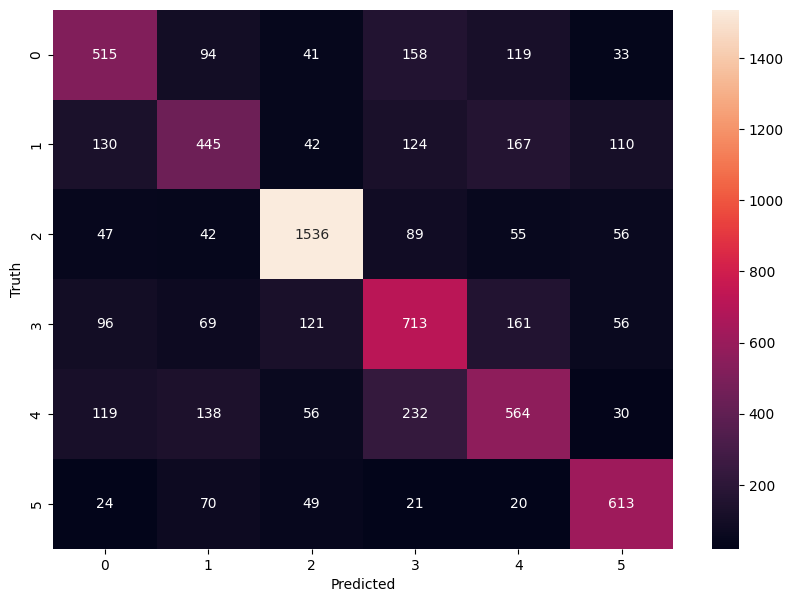

In [105]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test1,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')